# Clusteranalyse

Schritte zur Vorbereitung, später evtl. schon im Preprossessing erledigt:

Format
- Datumsspalte in Jahr, Monat, Tag trennen

Daten entfernen
- **Zeilen** aus 2014 und 2025 entfernen, weil zu wenige Datenpunkte
- **Spalten** mit zu vielen fehlenden Werten entfernen (cut-off: 53% missing values)
- Alle Einträge für **Tehran** entfernen, weil die Stadt durch ihre extrem hohen Schadstoffwerte die Clusteranalyse verzerrt

Aktuell auch noch relevant, aber im großen Datensatz vielleicht nicht mehr
- Bestimmen, in welchen der 95 Städte für **alle Schadstoffe** Messwerte vorliegen --> 54 Städte

Clusteranalyse
- StandardScaler und KMeans importieren
- Liste der Schadstoffe definieren (pollutants)
- gruppierten ("City") und reduzierten ("dropna") mit Mittelwerten ("mean") df nach Städten und Schadstoffen für als Datengrundlage der Clusteranalyse erstellen (**df_cluster**). df-cluster hat 53 Zeilen (Städte) und 6 Spalten (Schadstoffe)
- Daten skalieren (**df_cluster_scaled**)
- mit Ellbow-Methode optimale Clusteranzahl bestimmen --> 5 Cluster (Silhouette wurde auch getestet, brachte keinen Mehrwert)
- mit Kmeans Clusterzuordnung durchführen (**df_cluster_numbers**)

Output


In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline

In [2]:
# Settings for displaying floats
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
df = pd.read_csv("../data/cleaned_data.csv")
df.head()

,Date,Country,City,aqi,co,d,dew,humidity,mepaqi,neph,...,wind-speed,Latitude,Longitude,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,2014-12-29,AT,graz,NaN,0.10,NaN,NaN,NaN,NaN,NaN,...,NaN,47.07,15.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2014-12-29,AT,innsbruck,NaN,0.10,NaN,NaN,NaN,NaN,NaN,...,NaN,47.26,11.39,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-12-29,AT,linz,NaN,0.10,NaN,NaN,NaN,NaN,NaN,...,NaN,48.31,14.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-12-29,AT,salzburg,NaN,0.10,NaN,NaN,NaN,NaN,NaN,...,NaN,47.80,13.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2014-12-29,AT,vienna,NaN,0.10,NaN,NaN,NaN,NaN,NaN,...,NaN,48.21,16.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.isna().sum()

Date                   0
Country                0
City                   0
aqi              1528620
co                590812
d                1566308
dew               636362
humidity          353744
mepaqi           1565563
neph             1563743
no2               271349
o3                356011
pm1              1562522
pm10              295157
pm25              242865
pol              1563549
precipitation    1438489
pressure          358256
psi              1567976
so2               495212
temperature       352069
uvi              1539270
wd               1488039
wind-gust         870253
wind-speed        376919
Latitude            2827
Longitude           2827
tavg              264457
tmin              293523
tmax              295276
prcp              606946
wdir              484221
wspd              417000
pres              453450
dtype: int64

In [5]:
# Data preparation: Manipulating the 'Date' column

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Split 'Date' column into 'year', 'month' and 'day'
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

# Remove 'Date' column
if 'Date' in df.columns:
    df.drop(columns=['Date'], inplace=True)

In [6]:
df.head()

,Country,City,aqi,co,d,dew,humidity,mepaqi,neph,no2,...,tavg,tmin,tmax,prcp,wdir,wspd,pres,year,month,day
0,AT,graz,NaN,0.10,NaN,NaN,NaN,NaN,NaN,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,12,29
1,AT,innsbruck,NaN,0.10,NaN,NaN,NaN,NaN,NaN,25.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,12,29
2,AT,linz,NaN,0.10,NaN,NaN,NaN,NaN,NaN,14.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,12,29
3,AT,salzburg,NaN,0.10,NaN,NaN,NaN,NaN,NaN,21.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,12,29
4,AT,vienna,NaN,0.10,NaN,NaN,NaN,NaN,NaN,9.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014,12,29


In [7]:
# Daten für 2014 & 2025 entfernen, weil zu wenige Datenpunkte

df = df[(df["year"] > 2014) & (df["year"] < 2025)]

In [8]:
# Tehran komplett entfernen, weil die Schadstoffwerte zu sehr von allen übrigen Städten abweichen
df = df[df["City"] != "Tehran"]

In [9]:
print("Tehran noch im DataFrame?", "Tehran" in df["City"].values)

Tehran noch im DataFrame? False


In [10]:
df['City'].nunique()

616

In [11]:
# Display the first 5 rows of the dataframe
df.head()

,Country,City,aqi,co,d,dew,humidity,mepaqi,neph,no2,...,tavg,tmin,tmax,prcp,wdir,wspd,pres,year,month,day
1226,AT,graz,NaN,0.10,NaN,NaN,NaN,NaN,NaN,22.40,...,-4.00,-6.40,0.40,0.00,NaN,3.50,NaN,2015,1,1
1227,AT,innsbruck,NaN,0.10,NaN,NaN,NaN,NaN,NaN,23.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,1
1228,AT,linz,NaN,0.10,NaN,NaN,NaN,NaN,NaN,17.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,1
1229,AT,salzburg,NaN,0.10,NaN,NaN,NaN,NaN,NaN,23.40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,1
1230,AT,vienna,NaN,0.10,NaN,NaN,NaN,NaN,NaN,7.80,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015,1,1


In [ ]:
df.shape

In [12]:
# Spalten mit zu vielen fehlenden Werten entfernen

# Berechnen, wie viele Prozent der Werte pro Spalte fehlen
missing_percent = df.isna().mean() * 100  

# Spalten auswählen, die weniger als 50% fehlende Werte haben
df_cleaned = df.loc[:, missing_percent <= 53]

# Ergebnis ausgeben
print(f"Anzahl der entfernten Spalten: {df.shape[1] - df_cleaned.shape[1]}")
print("Übrige Spalten:", df_cleaned.columns)


Anzahl der entfernten Spalten: 11
Übrige Spalten: Index(['Country', 'City', 'co', 'dew', 'humidity', 'no2', 'o3', 'pm10', 'pm25',
       'pressure', 'so2', 'temperature', 'wind-speed', 'Latitude', 'Longitude',
       'tavg', 'tmin', 'tmax', 'prcp', 'wdir', 'wspd', 'pres', 'year', 'month',
       'day'],
      dtype='object')


In [13]:
df_cleaned["City"].nunique()

616

In [ ]:
# # Mit Heatmap herausfinden, welche Städte für welche Schadstoffe fehlende Werte haben

# # Liste der Schadstoff-Features für das Clustering
# pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

# # DataFrame mit den Schadstoffen pro Stadt erstellen
# df_missing = df_cleaned.groupby("City")[pollutants].mean()

# # Boolean-Maske für fehlende Werte erstellen (True = fehlend, False = vorhanden)
# missing_data = df_missing.isna()

# # Größe der Grafik anpassen
# plt.figure(figsize=(8, 20))

# # Heatmap zeichnen (dunklere Farben = mehr fehlende Werte)
# sns.heatmap(missing_data, cmap="coolwarm", cbar=False, linewidths=0.5)

# # Achsentitel setzen
# plt.xlabel("Schadstoffe")
# plt.ylabel("Städte")
# plt.title("Heatmap der fehlenden Werte pro Stadt und Schadstoff")


In [ ]:
# missing_per_city = df_missing.isna().sum(axis=1)
# missing_per_city_sorted = missing_per_city.sort_values(ascending=False)
# print(missing_per_city_sorted.to_string())


## Code für Clusteranalyse (K-Means) zur Schadstoffbelastung

Input: df_cleaned

Output:

In [14]:
# Liste der Schadstoff-Features für das Clustering
pollutants = ["co", "no2", "o3", "so2", "pm10", "pm25"]

In [15]:
# Clusteranalyse zur Schadstoffbelastung

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Durchschnittliche Schadstoffwerte pro Stadt berechnen
df_pollutants = df_cleaned.groupby("City")[pollutants].mean().dropna()

In [16]:
df_pollutants.head()

,co,no2,o3,so2,pm10,pm25
City,,,,,,
abu dhabi,0.10,12.10,27.64,4.96,80.03,98.72
adana,4.02,11.21,16.58,4.21,31.45,68.21
adapazarı,18.48,12.65,16.49,19.86,38.06,71.70
adelaide,3.42,35.53,39.51,14.48,13.65,16.80
aguascalientes,7.13,19.18,56.37,5.97,76.27,108.93


In [17]:
df_pollutants.shape

(405, 6)

In [18]:
# Daten skalieren (K-Means ist empfindlich gegenüber unterschiedlichen Skalen)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_pollutants)

# Ergebnis als DataFrame zurückgeben
df_pollutants_scaled = pd.DataFrame(df_scaled, index=df_pollutants.index, columns=pollutants)

# Überprüfen, ob die Daten korrekt vorbereitet sind
df_pollutants_scaled.head()

,co,no2,o3,so2,pm10,pm25
City,,,,,,
abu dhabi,-0.63,0.23,0.79,0.01,2.50,1.45
adana,-0.19,0.08,-0.43,-0.09,0.02,0.35
adapazarı,1.44,0.32,-0.44,1.97,0.35,0.47
adelaide,-0.25,4.05,2.10,1.26,-0.89,-1.51
aguascalientes,0.17,1.38,3.96,0.14,2.30,1.82


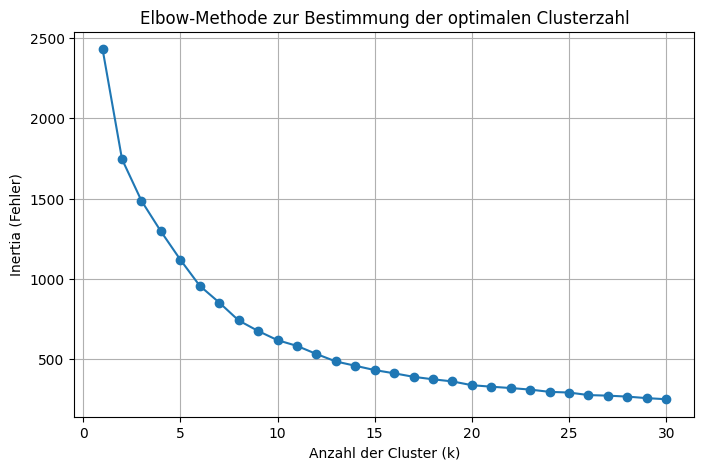

In [19]:
# Teste verschiedene Clusterzahlen (k = 1 bis 10)
inertia = []
k_values = range(1, 31)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_pollutants_scaled)
    inertia.append(kmeans.inertia_)  # Speichert den Fehler (Inertia)

# Elbow-Plot erstellen
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o', linestyle='-')
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Inertia (Fehler)")
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusterzahl")
plt.grid(True);

In [20]:
# K-Means-Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df_pollutants_scaled["Cluster"] = kmeans.fit_predict(df_pollutants_scaled)
df_pollutants_scaled.head()

,co,no2,o3,so2,pm10,pm25,Cluster
City,,,,,,,
abu dhabi,-0.63,0.23,0.79,0.01,2.50,1.45,3
adana,-0.19,0.08,-0.43,-0.09,0.02,0.35,0
adapazarı,1.44,0.32,-0.44,1.97,0.35,0.47,2
adelaide,-0.25,4.05,2.10,1.26,-0.89,-1.51,2
aguascalientes,0.17,1.38,3.96,0.14,2.30,1.82,3


In [21]:
# Neue Cluster-Zuordnung der Städte anzeigen
pollutants_cluster_numbers = df_pollutants_scaled[["Cluster"]].sort_values(by="Cluster")
pollutants_cluster_numbers

,Cluster
City,
mexico city,0
kunming,0
kütahya,0
lampang,0
lima,0
...,...
kolkata,3
khorramshahr,3
patna,3


In [27]:
cluster_counts = pollutants_cluster_numbers["Cluster"].value_counts().sort_index()
cluster_counts


Cluster
0    135
1    192
2     20
3     57
4      1
Name: count, dtype: int64

In [46]:
cluster_1_cities = pollutants_cluster_numbers[pollutants_cluster_numbers["Cluster"] == 1]


In [47]:
cluster_1_cities

,Cluster
City,
port elizabeth,1
bordeaux,1
portland,1
pécs,1
valladolid,1
...,...
livorno,1
las palmas de gran canaria,1
liège,1


In [30]:
df_pollutants_with_cluster_numbers = pd.concat([df_pollutants, pollutants_cluster_numbers], axis=1)
df_pollutants_with_cluster_numbers.head()

,co,no2,o3,so2,pm10,pm25,Cluster
City,,,,,,,
abu dhabi,0.10,12.10,27.64,4.96,80.03,98.72,3
adana,4.02,11.21,16.58,4.21,31.45,68.21,0
adapazarı,18.48,12.65,16.49,19.86,38.06,71.70,2
adelaide,3.42,35.53,39.51,14.48,13.65,16.80,2
aguascalientes,7.13,19.18,56.37,5.97,76.27,108.93,3


In [31]:
df_pollutants_with_cluster_numbers.to_csv("df_pollutants.csv", index=True)  # Index speichern, damit die Städtenamen erhalten bleiben


In [ ]:
# # Delhi wird bei 5 und 6 Clustern von KMeans als eigenes Cluster isoliert.
# # Test, ob DBSCAN eine andere Clusterbildung erzielt

# from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=3.5, min_samples=4)  # Parameter ggf. anpassen
# df_cluster["Cluster_DBSCAN"] = dbscan.fit_predict(df_scaled)

In [ ]:
# df_cluster["Cluster_DBSCAN"].value_counts()


In [ ]:
# df_cluster[df_cluster.index == "Delhi"]

Entscheidung: Tehran war schon rausgenommen, weil es ein eigenes Cluster bildet. Ohne Tehran bildet Delhi ein eigenes Cluster. Das lassen wir jetzt erst mal so.

## Zusammenführung Geodaten und Clusternummern

In [32]:
df_coords = df.set_index("City")[["Longitude", "Latitude"]]


In [33]:
df_coords.head()

,Longitude,Latitude
City,,
graz,15.45,47.07
innsbruck,11.39,47.26
linz,14.29,48.31
salzburg,13.04,47.80
vienna,16.37,48.21


In [34]:
df_coords = df.groupby("City")[["Longitude", "Latitude"]].mean()
len(df_coords)

616

In [35]:
df_pollutants_with_clustern_numbers_and_geodata = df_pollutants_with_cluster_numbers.join(df_coords, how="left")
df_pollutants_with_clustern_numbers_and_geodata.head()

,co,no2,o3,so2,pm10,pm25,Cluster,Longitude,Latitude
City,,,,,,,,,
abu dhabi,0.10,12.10,27.64,4.96,80.03,98.72,3,54.40,24.45
adana,4.02,11.21,16.58,4.21,31.45,68.21,0,35.33,36.99
adapazarı,18.48,12.65,16.49,19.86,38.06,71.70,2,30.40,40.78
adelaide,3.42,35.53,39.51,14.48,13.65,16.80,2,138.60,-34.93
aguascalientes,7.13,19.18,56.37,5.97,76.27,108.93,3,-102.28,21.88


In [36]:
df_pollutants_with_clustern_numbers_and_geodata = df_pollutants_with_clustern_numbers_and_geodata.dropna(subset=["Longitude", "Latitude"])


In [37]:
len(df_pollutants_with_clustern_numbers_and_geodata)

404

## Cluster farbig plotten

In [38]:


import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt

# Weltkarte laden
world = gpd.read_file(geodatasets.get_path("naturalearth.land"))

# Städte aus df_geodata in einen GeoDataFrame umwandeln
gdf_cities = gpd.GeoDataFrame(df_pollutants_with_clustern_numbers_and_geodata, 
                              geometry=gpd.points_from_xy(df_pollutants_with_clustern_numbers_and_geodata["Longitude"], df_pollutants_with_clustern_numbers_and_geodata["Latitude"]))


In [39]:
import matplotlib.colors as mcolors

# Eigene 5-Farben-Palette aus 'tab10' extrahieren
custom_cmap = mcolors.ListedColormap(plt.get_cmap("tab10").colors[:5])

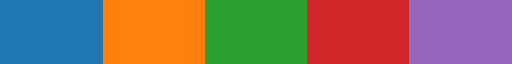

In [40]:
custom_cmap

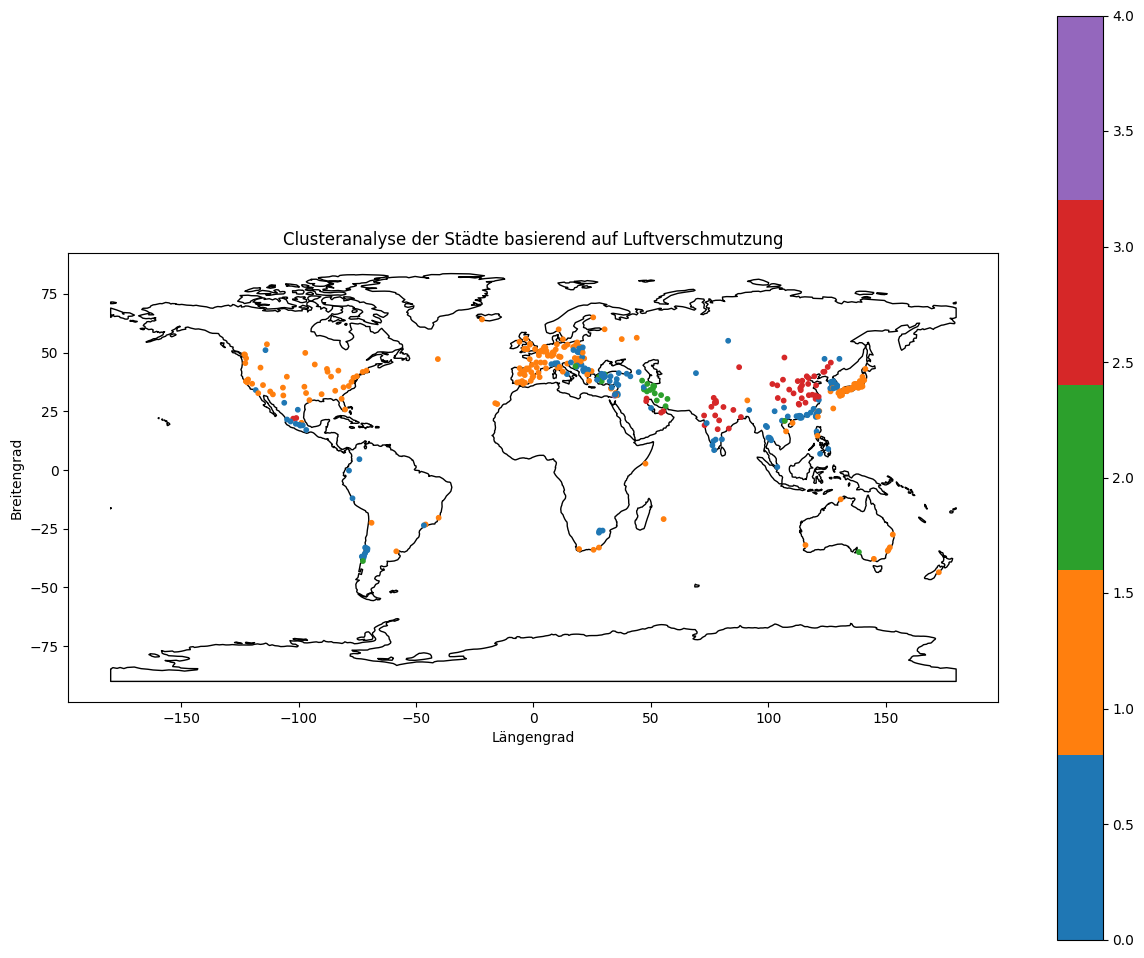

In [42]:
# Plot erstellen
fig, ax = plt.subplots(figsize=(15, 12))

# Umrisse der Weltkarte plotten
world.plot(ax=ax, color='white', edgecolor='black')

# Städte als farbige Punkte nach Cluster einfärben
scatter = gdf_cities.plot(column="Cluster", cmap=custom_cmap, ax=ax, markersize=10, legend=True, alpha=1.0)

# Titel & Achsen
plt.title("Clusteranalyse der Städte basierend auf Luftverschmutzung")
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")

plt.savefig("../Images/cluster_plot.png", dpi=300, bbox_inches="tight")

plt.show()



## Interpretation der Cluster



In [43]:
cluster_summary = df_pollutants_with_cluster_numbers.groupby("Cluster").mean()
cluster_summary


,co,no2,o3,so2,pm10,pm25
Cluster,,,,,,
0,6.60,11.47,18.22,4.60,34.45,67.51
1,2.46,7.74,21.45,2.29,16.77,37.16
2,18.44,23.26,16.60,27.57,43.42,60.34
3,7.42,14.54,23.41,6.53,67.38,109.18
4,138.73,4.86,38.67,1.09,35.55,58.48
